In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_custom_dataset(dataset_path, img_size=(224, 224)):
    """Load custom dataset from directory structure"""

    def load_images_from_folder(folder_path):
        images = []
        labels = []

        class_names = sorted([d for d in os.listdir(folder_path)
                            if os.path.isdir(os.path.join(folder_path, d))])

        print(f"Found classes: {class_names}")

        for class_name in class_names:
            class_folder = os.path.join(folder_path, class_name)
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            print(f"Loading {len(image_files)} images from {class_name}...")

            for img_file in image_files:
                img_path = os.path.join(class_folder, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

        return np.array(images), np.array(labels)

    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    print("Loading training data...")
    X_train, Y_train_names = load_images_from_folder(train_path)

    print("\nLoading test data...")
    X_test, Y_test_names = load_images_from_folder(test_path)

    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([Y_train_names, Y_test_names]))

    Y_train = label_encoder.transform(Y_train_names).reshape(-1, 1)
    Y_test = label_encoder.transform(Y_test_names).reshape(-1, 1)

    print(f"\nClass mapping:")
    for i, class_name in enumerate(label_encoder.classes_):
        count_train = np.sum(Y_train == i)
        count_test = np.sum(Y_test == i)
        print(f"  {i}: {class_name} - Train: {count_train}, Test: {count_test}")

    return (X_train, Y_train), (X_test, Y_test), label_encoder

In [4]:

# Load dataset
dataset_path = '/content/drive/MyDrive/dataset-v2'
(X_train, Y_train), (X_test, Y_test), label_encoder = load_custom_dataset(dataset_path)

print(f"\nDataset loaded successfully!")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

class_names = label_encoder.classes_
print(f"Classes: {class_names}")

Loading training data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 154 images from avoy...
Loading 145 images from navin...
Loading 156 images from rakin...
Loading 145 images from yousha...

Loading test data...
Found classes: ['avoy', 'navin', 'rakin', 'yousha']
Loading 4 images from avoy...
Loading 5 images from navin...
Loading 4 images from rakin...
Loading 5 images from yousha...

Class mapping:
  0: avoy - Train: 154, Test: 4
  1: navin - Train: 145, Test: 5
  2: rakin - Train: 156, Test: 4
  3: yousha - Train: 145, Test: 5

Dataset loaded successfully!
X_train shape: (600, 224, 224, 3), Y_train shape: (600, 1)
X_test shape: (18, 224, 224, 3), Y_test shape: (18, 1)
Classes: ['avoy' 'navin' 'rakin' 'yousha']


In [5]:
# Shuffle data
train_indices = np.random.permutation(len(X_train))
X_train = X_train[train_indices]
Y_train = Y_train[train_indices]

test_indices = np.random.permutation(len(X_test))
X_test = X_test[test_indices]
Y_test = Y_test[test_indices]


In [6]:
# Normalize
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


In [8]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(Y_train.flatten()),
    y=Y_train.flatten()
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("\nBalanced class weights (computed from data):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weight_dict[i]:.2f}")


Balanced class weights (computed from data):
  avoy: 0.97
  navin: 1.03
  rakin: 0.96
  yousha: 1.03


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers

num_classes = len(class_names)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Start with frozen base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,804,612 (94.62 MB)

 Trainable params: 1,215,364 (4.64 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
# ============ KEY IMPROVEMENT 5: Callbacks for Better Training ============
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [12]:
print("\n" + "="*50)
print("PHASE 1: Training with frozen ResNet50 base")
print("="*50)

history1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_test, Y_test),
    epochs=25,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)



PHASE 1: Training with frozen ResNet50 base


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.2143 - loss: 12.7519
Epoch 1: val_accuracy improved from -inf to 0.27778, saving model to best_model.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2141 - loss: 12.7414 - val_accuracy: 0.2778 - val_loss: 11.9954 - learning_rate: 1.0000e-04
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.2622 - loss: 11.8370
Epoch 2: val_accuracy did not improve from 0.27778
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy: 0.2625 - loss: 11.8249 - val_accuracy: 0.2778 - val_loss: 11.1352 - learning_rate: 1.0000e-04
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.2465 - loss: 10.9531
Epoch 3: val_accuracy did not improve from 0.27778
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy: 0.2463 - loss: 10.9438 - val_accuracy: 0.2778 - val_loss: 10.3615 - learning_rate: 1.0000e-04
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.2707 - loss: 10.2152
Epoch 4: val_accuracy did not improve from 0.27778
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 671ms/step - accuracy: 0.2698 - loss: 10.2091 - val_accuracy: 0.2778 - val_loss: 9.6651 - learning_rate: 1.0000e-04


In [13]:
print("\n" + "="*50)
print("PHASE 2: Fine-tuning top layers of ResNet50")
print("="*50)

# Unfreeze the last 20 layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=16),  # Smaller batch size
    validation_data=(X_test, Y_test),
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


PHASE 2: Fine-tuning top layers of ResNet50
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.2604 - loss: 4.4880
Epoch 1: val_accuracy did not improve from 0.27778
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 619ms/step - accuracy: 0.2599 - loss: 4.4883 - val_accuracy: 0.2222 - val_loss: 8.6705 - learning_rate: 1.0000e-05
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.3051 - loss: 4.5578
Epoch 2: val_accuracy did not improve from 0.27778
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.3046 - loss: 4.5577 - val_accuracy: 0.2222 - val_loss: 15.9631 - learning_rate: 1.0000e-05
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2901 - loss: 4.5163
Epoch 3: val_accuracy did not improve from 0.27778
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.2898 - loss: 4.5153 - val_accuracy: 0.2222 - val_loss: 12.2502 - learning_rate: 1.0000e-05
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2913 - loss: 4.4449
Epoch 4: val_accura

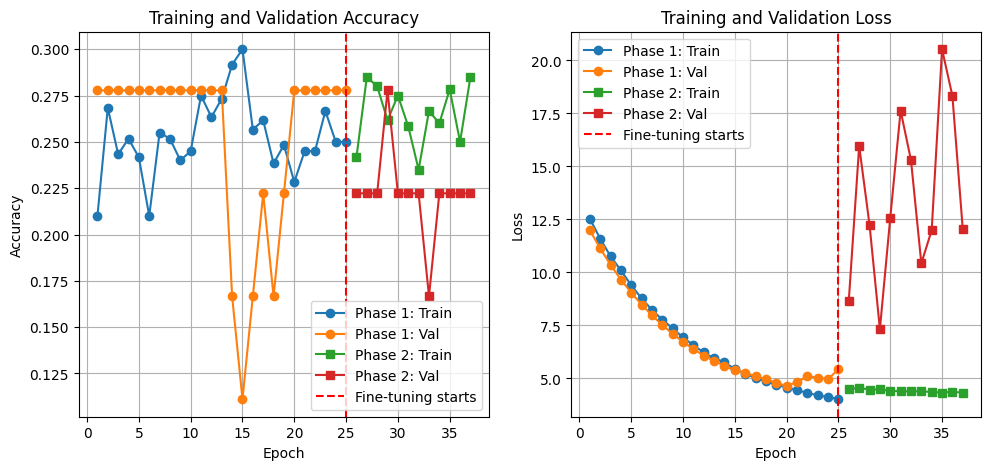

In [14]:
# Combine histories
total_epochs1 = len(history1.history['accuracy'])
total_epochs2 = len(history2.history['accuracy'])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, total_epochs1 + 1), history1.history['accuracy'], 'o-', label='Phase 1: Train')
plt.plot(range(1, total_epochs1 + 1), history1.history['val_accuracy'], 'o-', label='Phase 1: Val')
plt.plot(range(total_epochs1 + 1, total_epochs1 + total_epochs2 + 1),
         history2.history['accuracy'], 's-', label='Phase 2: Train')
plt.plot(range(total_epochs1 + 1, total_epochs1 + total_epochs2 + 1),
         history2.history['val_accuracy'], 's-', label='Phase 2: Val')
plt.axvline(x=total_epochs1, color='red', linestyle='--', label='Fine-tuning starts')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, total_epochs1 + 1), history1.history['loss'], 'o-', label='Phase 1: Train')
plt.plot(range(1, total_epochs1 + 1), history1.history['val_loss'], 'o-', label='Phase 1: Val')
plt.plot(range(total_epochs1 + 1, total_epochs1 + total_epochs2 + 1),
         history2.history['loss'], 's-', label='Phase 2: Train')
plt.plot(range(total_epochs1 + 1, total_epochs1 + total_epochs2 + 1),
         history2.history['val_loss'], 's-', label='Phase 2: Val')
plt.axvline(x=total_epochs1, color='red', linestyle='--', label='Fine-tuning starts')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()

In [16]:
# ============ DETAILED EVALUATION ============
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\n' + "="*50)
print(f'FINAL TEST ACCURACY: {test_acc:.4f}')
print(f'FINAL TEST LOSS: {test_loss:.4f}')
print("="*50)

print("\n" + "="*50)
print("CLASSIFICATION REPORT:")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2778 - loss: 7.3228

FINAL TEST ACCURACY: 0.2778
FINAL TEST LOSS: 7.3228

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        avoy       0.00      0.00      0.00         4
       navin       0.00      0.00      0.00         5
       rakin       0.00      0.00      0.00         4
      yousha       0.28      1.00      0.43         5

    accuracy                           0.28        18
   macro avg       0.07      0.25      0.11        18
weighted avg       0.08      0.28      0.12        18



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


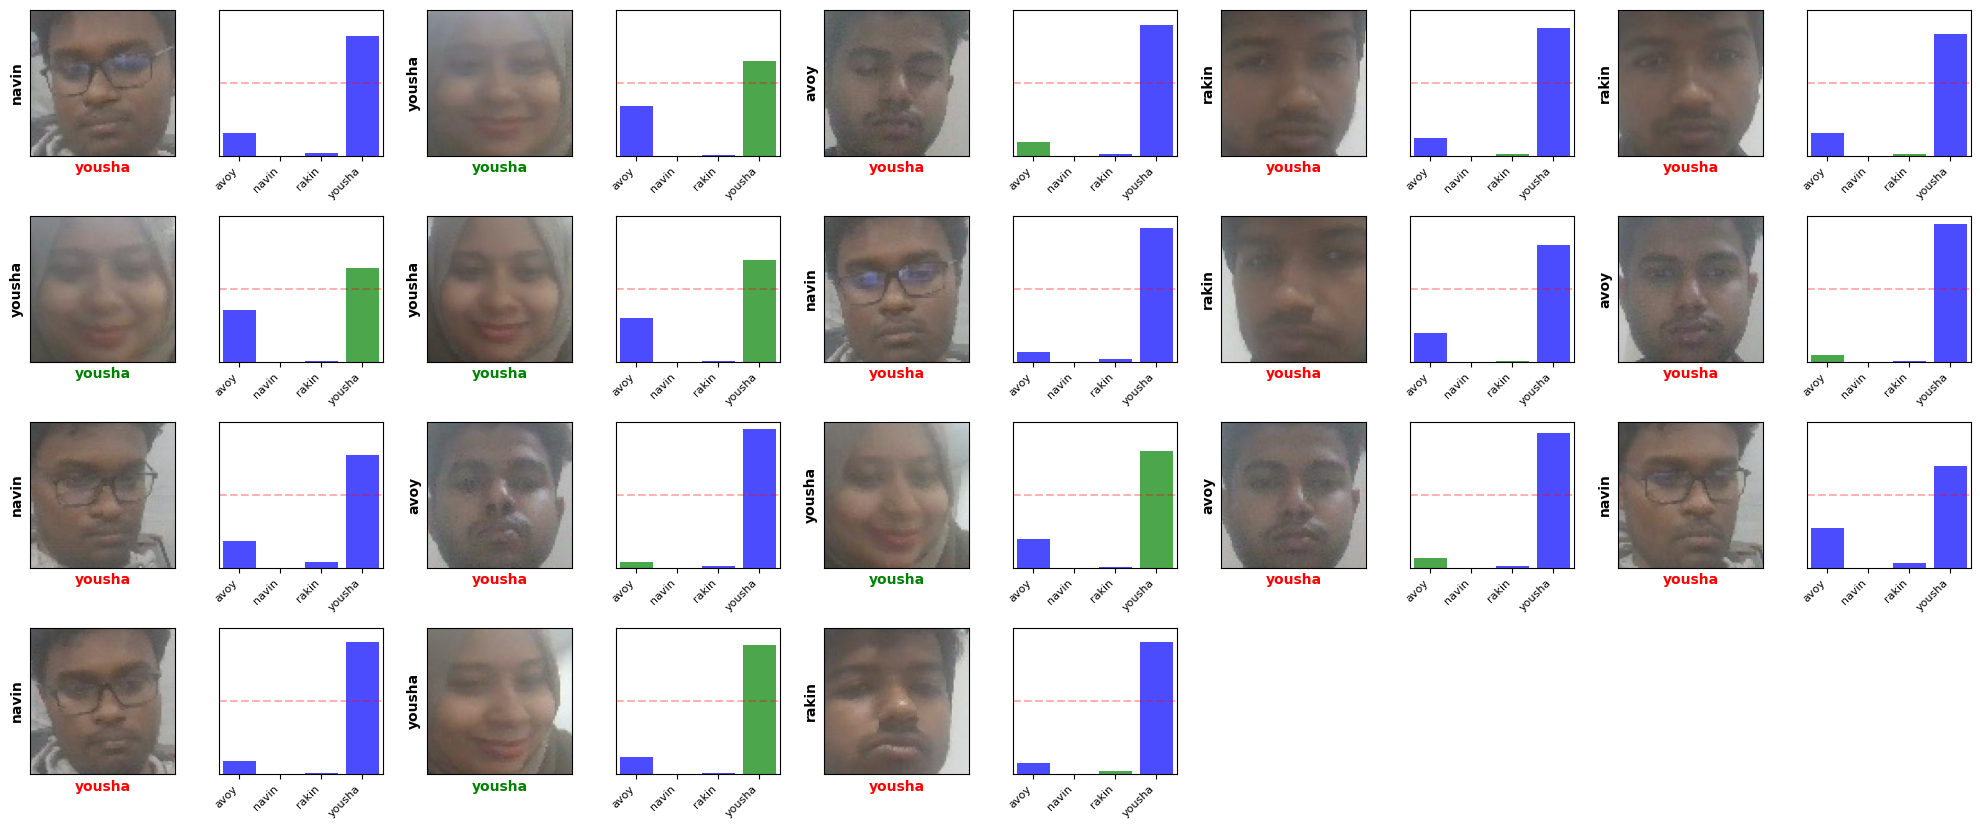

In [17]:
num_predictions = min(25, len(X_test))
rows = 5
cols = 5

plt.figure(figsize=(20, 10))
for i in range(num_predictions):
    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_names[Y_test[i][0]], fontsize=10, fontweight='bold')

    if Y_test[i][0] == np.argmax(predictions[i]):
        plt.xlabel(class_names[np.argmax(predictions[i])], color='green', fontsize=10, fontweight='bold')
    else:
        plt.xlabel(class_names[np.argmax(predictions[i])], color='red', fontsize=10, fontweight='bold')

    plt.subplot(rows, 2*cols, 2*i+2)
    colors = ['green' if j == Y_test[i][0] else 'blue' for j in range(num_classes)]
    plt.bar(range(num_classes), predictions[i], color=colors, alpha=0.7)
    plt.yticks([])
    plt.xticks(range(num_classes), class_names, rotation=45, ha='right', fontsize=8)
    plt.ylim([0, 1])
    plt.xlim([-0.5, num_classes-0.5])
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
model.save('face_recognition_model_improved.h5')
print("\nModel saved to: face_recognition_model_improved.h5")

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to: label_encoder.pkl")

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)


Model saved to: face_recognition_model_improved.h5
Label encoder saved to: label_encoder.pkl

TRAINING COMPLETE!
